In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import SimpleITK as sitk

In [2]:
import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.parallel as ct_para
import ct_projector.prior.cupy as ct_prior
import ct_projector.recon.cupy as ct_recon

import ct_projector.projector.numpy.parallel as ct_para_numpy

In [3]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
img = np.copy(img, 'C')
spacing = np.array(spacing[::-1])

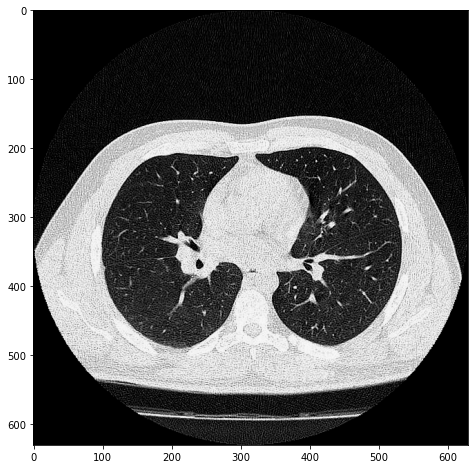

In [4]:
img_ref = img[:, [img.shape[1]//2], ...]

plt.figure(figsize=[8, 8])
plt.imshow(img_ref[0, 0], 'gray', vmin=0, vmax=1.2)

In [5]:
device = 0
down_rate = 16

In [6]:
projector = ct_projector.ct_projector()
projector.from_file('projector_fan.cfg')
projector.nv = 1
projector.nz = 1
projector.ny = img_ref.shape[2]
projector.nx = img_ref.shape[3]
projector.du = projector.du * projector.dso / projector.dsd
angles = projector.get_angles()
angles_sparse = np.copy(angles[::down_rate], 'C')

In [7]:
cp.cuda.Device(device).use()

curef = cp.array(img_ref, order='C')
cuangles = cp.array(angles, order='C')
cuangles_sparse = cp.array(angles_sparse, order='C')

projector.set_projector(ct_para.distance_driven_fp, angles=cuangles_sparse)
projector.set_backprojector(ct_para.distance_driven_bp, angles=cuangles_sparse)

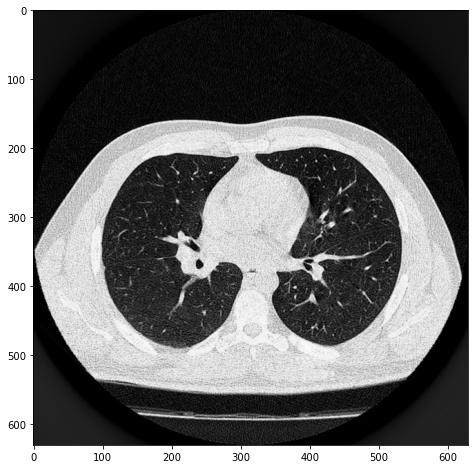

In [8]:
cuprj = projector.fp(curef, angles=cuangles)
prj = cuprj.get()
fprj = ct_para_numpy.ramp_filter(projector, prj, 'rl')
fbp = ct_para_numpy.distance_driven_bp(projector, fprj, angles, True)

plt.figure(figsize=[8, 8])
plt.imshow(fbp[0, 0], 'gray', vmin=0, vmax=1.2)

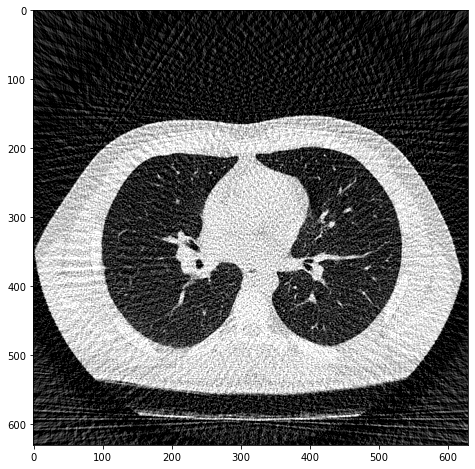

In [9]:
cuprj_sparse = projector.fp(curef, angles=cuangles_sparse)
prj_sparse = cuprj_sparse.get()
fprj = ct_para_numpy.ramp_filter(projector, prj_sparse, 'rl')
fbp_sparse = ct_para_numpy.distance_driven_bp(projector, fprj, angles_sparse, True)

plt.figure(figsize=[8, 8])
plt.imshow(fbp_sparse[0, 0], 'gray', vmin=0, vmax=1.2)

In [38]:
# TV reconstruction
niter = 1000
nos = 12
nesterov = 0.5
beta = 0.0001
zero_init = True

projector.nview = len(cuangles_sparse)
projector_norm = projector.calc_projector_norm()
cunorm_img = projector.calc_norm_img() / projector_norm / projector_norm

cufbp_sparse = cp.array(fbp_sparse, order='C')
if zero_init:
    curecon = cp.zeros(cufbp_sparse.shape, cp.float32)
    cunesterov = cp.zeros(cufbp_sparse.shape, cp.float32)
else:    
    curecon = cp.copy(cufbp_sparse)
    cunesterov = cp.copy(curecon)

for i in range(niter):
    for os in range(nos):
        inds = np.arange(os, len(cuangles_sparse), nos)
        cuangles_current = cp.copy(cuangles_sparse[inds], 'C')
        cuprj_current = cp.copy(cuprj_sparse[:, inds, ...], 'C')

        curecon = ct_recon.sqs_one_step(
            projector,
            cunesterov,
            cuprj_current,
            cunorm_img,
            projector_norm,
            beta,
            ct_prior.tv_sqs,
            {'weights': [1, 1, 1]},
            nos,
            {'angles': cuangles_current},
            {'angles': cuangles_current},
            return_loss=False
        )

        cunesterov = curecon + nesterov * (curecon - cunesterov)

    _, data_loss, tv_loss = ct_recon.sqs_one_step(
        projector,
        curecon,
        cuprj_sparse,
        cunorm_img,
        projector_norm,
        beta,
        ct_prior.tv_sqs,
        {'weights': [1, 1, 1]},
        1,
        return_loss=True
    )

    if (i + 1) % 100 == 0:
        print(i + 1, data_loss, tv_loss)

0,1,2,3,4,5,6,7,8,9,
100 0.25524956 14325.93
200 0.26034883 13502.886
300 0.26364806 13154.048
400 0.26580447 12974.361
500 0.26724583 12875.5205
600 0.2681415 12821.068
700 0.26874387 12790.105
800 0.26917174 12771.537
900 0.26946485 12760.042
1000 0.26967826 12752.719


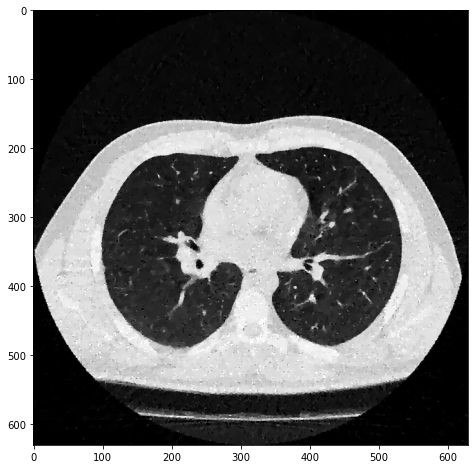

In [39]:
recon = curecon.get()
plt.figure(figsize=[8, 8])
plt.imshow(recon[0, 0], 'gray', vmin=0, vmax=1.2)